In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

## 读取数据集


In [2]:
training_d = pd.read_csv('./dataset-20211103/training.csv')
test_d = pd.read_csv('./dataset-20211103/test.csv')

## 预处理， 简单的将其转为独热码


In [3]:
labels=training_d['evaluation'].values
labels[labels=='unacc']=0
labels[labels=='acc']=1
labels=labels.astype('uint8')

In [4]:
train_1 = training_d.drop('evaluation', axis=1)

In [5]:
input_ = pd.get_dummies(train_1).values
input_.shape

(1115, 21)

In [44]:
#转换为tensor格式
train_features = torch.tensor(input_, dtype = torch.float32)
train_labels = torch.tensor(labels, dtype = torch.float32)

## 定义网络层


In [7]:
#data_iter
from torch.utils import data
def load_array(data_arrays, batch_size, istrain=True):
    '''pytorch 迭代器'''
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size, shuffle=istrain)
batch_size = 64

测试一下

In [8]:
data_iter = load_array((train_features,train_labels),batch_size)

In [9]:
next(iter(data_iter))[0].shape,next(iter(data_iter))[1].shape

(torch.Size([64, 21]), torch.Size([64]))

In [26]:
net = nn.Sequential(nn.Linear(input_.shape[1],64), nn.ReLU(), nn.Dropout(0.2), 
                   nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.2), nn.Linear(32,2))

In [27]:
X= torch.rand(size = (1000, 21))

In [28]:
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Linear output shape:	 torch.Size([1000, 64])
ReLU output shape:	 torch.Size([1000, 64])
Dropout output shape:	 torch.Size([1000, 64])
Linear output shape:	 torch.Size([1000, 32])
ReLU output shape:	 torch.Size([1000, 32])
Dropout output shape:	 torch.Size([1000, 32])
Linear output shape:	 torch.Size([1000, 2])


## 定义损失函数，优化器等

In [13]:
loss  = nn.CrossEntropyLoss()

In [14]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

## 训练


In [63]:
def train_gpu(net, train_features,train_labels,test_features,test_labels, num_epochs, lr,batch_size,device):
    '''This function is to train the model'''
    def init_weights(m):
        if type(m)==nn.Linear:
            #initialization
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    #check where we are training 
    print('training on:', device)
    #transfer our data into it
    net.to(device)
    #define the optimizer and loss
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    #for calculating the loss
    train_ls, test_ls=[],[]
    train_iter = load_array((train_features,train_labels),batch_size)
    for epoch in range(num_epochs):
        net.train()
        for X,y in train_iter:
            optimizer.zero_grad()#for every batch zero the gradient
            X, y = X.to(device), y.to(device)#transfer
            y_hat = net(X)#y_hat 
            l = loss(y_hat, y.long())#cal loss
            l.backward()#back propergation
            optimizer.step()#iteration
        with torch.no_grad():
            train_ls.append(loss(net(train_features),train_labels.long()))
            if test_labels is not None:
                test_ls.append(loss(net(test_features), test_labels.long()))
    return train_ls,test_ls

## 由于数据量过少，使用交叉验证

In [67]:
def k_fold_data(k, i, features, labels):
    assert k>1, 'k must be at least 2!'
    '''function of splitting into k fold'''
    #get each fold_num
    fold_size = features.shape[0]//k
    x_train=None
    y_train=None
    for j in range(k):
        #distribute it into different set
        idx = slice(j*fold_size,(j+1)*fold_size)
        #divide it into different area
        X = features[idx,:]
        y = labels[idx]
        if j==i:
            #choose the ith part become the validation set
            valid_x, valid_y = X,y
        elif x_train is None:
            x_train = X
            y_train = y
        else:
            #concat it 
            x_train = torch.cat([x_train,X],dim=0)
            y_train = torch.cat([y_train,y],dim=0)
    return x_train,y_train, valid_x,valid_y

def k_fold_loss(k, net,feature_train, labels_train, num_epochs, lr, batch_size):
    '''function of getting the mean of the loss'''
    train_loss_total, valid_loss_total = 0,0
    for i in range(k):
        total=k_fold_data(k,i,feature_train, labels_train)
        train_ls, valid_ls = train_gpu(net,*total,num_epochs,lr,batch_size,'cpu')
        #print(train_ls,valid_ls)
        train_loss_total += train_ls[-1]
        valid_loss_total += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='cross_entropy', xlim=[1, num_epochs],
                     legend=['train', 'valid'],)
        print(f'fold {i + 1}, train cross entropy loss {float(train_ls[-1]):f}, '
              f'valid cross entropy loss {float(valid_ls[-1]):f}')
    return train_loss_total / k, valid_loss_total / k

In [56]:
train_features.dtype

torch.float32

training on: cpu
fold 1, train cross entropy loss 0.003567, valid cross entropy loss 0.044888
training on: cpu
fold 2, train cross entropy loss 0.013464, valid cross entropy loss 0.006489
training on: cpu
fold 3, train cross entropy loss 0.008257, valid cross entropy loss 0.038832
training on: cpu
fold 4, train cross entropy loss 0.015244, valid cross entropy loss 0.034677
training on: cpu
fold 5, train cross entropy loss 0.011200, valid cross entropy loss 0.040645


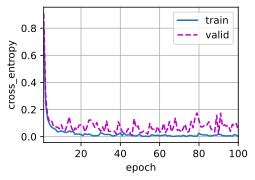

In [68]:
k , num_epochs, lr, batch_size = 5, 100, 0.01, 32
training_loss, valid_loss = k_fold_loss(k, net,train_features, train_labels, num_epochs,lr,batch_size)

In [69]:
training_loss,valid_loss


(tensor(0.0103), tensor(0.0331))